## RA2CE Feature: adaptation measures

This notebook explains how users can create different adaptation options that will influence the calculated damages and losses on roads. It also performs a Cost-Benefit Analysis (CBA) for each of the adaptation option to explore the cost effictiveness of these options.

In [1]:
from pathlib import Path
from ra2ce.analysis.analysis_config_wrapper import AnalysisConfigWrapper
from ra2ce.analysis.analysis_input_wrapper import AnalysisInputWrapper
from ra2ce.ra2ce_handler import Ra2ceHandler
from ra2ce.network.network_config_data.enums.aggregate_wl_enum import AggregateWlEnum
from ra2ce.network.network_config_data.enums.source_enum import SourceEnum
from ra2ce.analysis.analysis_config_data.analysis_config_data import (
    AnalysisConfigData,
    AnalysisSectionAdaptation,
    AnalysisSectionAdaptationOption,
    AnalysisSectionDamages,
    AnalysisSectionLosses,
)
from ra2ce.analysis.analysis_config_data.enums.analysis_damages_enum import (
    AnalysisDamagesEnum,
)
from ra2ce.analysis.analysis_config_data.enums.analysis_enum import AnalysisEnum
from ra2ce.analysis.analysis_config_data.enums.analysis_losses_enum import (
    AnalysisLossesEnum,
)
from ra2ce.analysis.analysis_config_data.enums.damage_curve_enum import DamageCurveEnum
from ra2ce.analysis.analysis_config_data.enums.event_type_enum import EventTypeEnum
from ra2ce.analysis.analysis_config_data.enums.traffic_period_enum import (
    TrafficPeriodEnum,
)
from ra2ce.analysis.analysis_config_data.enums.trip_purpose_enum import TripPurposeEnum
from ra2ce.analysis.analysis_config_data.enums.weighing_enum import WeighingEnum
from ra2ce.analysis.analysis_config_wrapper import AnalysisConfigWrapper
from ra2ce.analysis.analysis_input_wrapper import AnalysisInputWrapper
from ra2ce.network.network_config_data.enums.aggregate_wl_enum import AggregateWlEnum
from ra2ce.network.network_config_data.network_config_data import (
    HazardSection,
    NetworkConfigData,
    NetworkSection,
)
from ra2ce.network.network_config_wrapper import NetworkConfigWrapper
from ra2ce.analysis.adaptation.adaptation import Adaptation
from ra2ce.analysis.analysis_config_wrapper import AnalysisConfigWrapper
from ra2ce.analysis.analysis_input_wrapper import AnalysisInputWrapper


c:\Users\hauth\miniforge3\envs\ra2ce_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
root_dir = Path("data", "adaptation")

static_path = root_dir.joinpath("static")
hazard_path =static_path.joinpath("hazard")
network_path = static_path.joinpath("network")
output_path=root_dir.joinpath("output")

input_path = root_dir.joinpath("input") # path of the data files for all adaptation options and BAU

### Network config

The network must first be configured and overlaid with a hazard map. The current workflow only supports the following configurations:

- AggregateWlENum: only MEAN (or try with other)
- SourceEnum must be set to SHAPEFILE. This is because we are running Losses which requires information about the traffic intensities, 
- Adaptation is for now only event-based for a single hazard map. Therefore the name of the hazard map should not start with "RP"

In [3]:

_network_section = NetworkSection(
    source= SourceEnum.SHAPEFILE,       
    primary_file = [network_path.joinpath("network.shp")], 
    file_id = "ID",
    link_type_column='highway',
    save_gpkg=True
)

_hazard = HazardSection(
    hazard_map=[Path(file) for file in hazard_path.glob("*.tif")],
    hazard_field_name= ['waterdepth'],
    aggregate_wl = AggregateWlEnum.MEAN,
    hazard_crs = 'EPSG:4326' 
)


_network_config_data = NetworkConfigData(
    root_path=root_dir,
    static_path=static_path,
    output_path=output_path,
    network=_network_section,
    hazard=_hazard
    )

In [4]:

handler = Ra2ceHandler.from_config(_network_config_data, None)

handler.configure()
handler.run_analysis()

## Losses and Damages configuration

The configuration for the losses and damages analysis must be defined here. The general configurations of losses and damages are shared for all adaptation options! The only difference between the options are the 
input files used: resilience_curve.csv, traffic_intensities.csv, values_of_time.csv, damage_curves.csv and repair_cost

For example, it is (currenlty) NOT possible for Adaptation option 1 to have `production_loss_per_capita_per_hour=42` and for option 2: `production_loss_per_capita_per_hour=20`

### Damages:

- Since we are simulating the adaptation effects by modifying the hazard curves, only the Manual damage curve type is allowed: `DamageCurveEnum.MAN`
- `EventTypeEnum.EVENT` is mandatory since we are dealing with an event-base adaptation.

### Losses:

- Both single link and multi link losses are accepted: `AnalysisLossesEnum`
- `EventTypeEnum.EVENT` is mandatory since we are dealing with an event-base adaptation.
- All the other arguments can be modified 

In [5]:

_damages_section = AnalysisSectionDamages(
        analysis=AnalysisDamagesEnum.DAMAGES,
        event_type=EventTypeEnum.EVENT,
        damage_curve=DamageCurveEnum.MAN,
        save_gpkg=True,
        save_csv=True,
    )

    # - losses
_multi_link_losses_section = AnalysisSectionLosses(
            analysis=AnalysisLossesEnum.MULTI_LINK_LOSSES,
            event_type=EventTypeEnum.EVENT,
            weighing=WeighingEnum.TIME,
            threshold=0,
            production_loss_per_capita_per_hour=42,
            hours_per_traffic_period=8,
            traffic_period=TrafficPeriodEnum.DAY,
            trip_purposes=[
                TripPurposeEnum.BUSINESS,
                TripPurposeEnum.COMMUTE,
                TripPurposeEnum.FREIGHT,
                TripPurposeEnum.OTHER,
            ],
            resilience_curves_file=input_path.joinpath("resilience_curve.csv"),
            traffic_intensities_file=input_path.joinpath("traffic_intensities.csv"),
            values_of_time_file=input_path.joinpath("values_of_time.csv"),
            save_gpkg=True,
            save_csv=True,
        )



## Adaptation options:

The adaptation options can now be defined. 

1. The `AnalysisSectionAdaptation` must be filled with general inputs applicable to all adaptation options, such as the discount rate, ...
2. A collection of adaptation options is to be specified:
    - Each adaptation option has an `id` which must match the input data structure in order to assign the input files correctly
    - The first adaptation option represents the initial situation (Business As Usual) and only requires a `name` and `id`.
    - The following adaptation options have extra required attributes to calculate the cost: `construction_cost`, `construction_interval`, 'maintenance_cost', 'maintenance_interval'

In [6]:

# - adaptation
_adaptation_options = [
    AnalysisSectionAdaptationOption(
            id="AO0",
            name="No adaptation",
        ),
        AnalysisSectionAdaptationOption(
            id="AO1",
            name="Cheap construction, expensive maintenance",
            construction_cost=1000.0,
            construction_interval=10.0,
            maintenance_cost=200.0,
            maintenance_interval=3.0,
        ),
        AnalysisSectionAdaptationOption(
            id="AO2",
            name="Expensive construction, cheap maintenance",
            construction_cost=5000.0,
            construction_interval=100.0,
            maintenance_cost=50.0,
            maintenance_interval=3.0,
        ),
]
_adaptation_section = AnalysisSectionAdaptation(
        analysis=AnalysisEnum.ADAPTATION,
        losses_analysis=AnalysisLossesEnum.MULTI_LINK_LOSSES,
        adaptation_options=_adaptation_options,
        discount_rate=0.025,  # correcting inflation 0.025 = 2.5%
        initial_frequency=0.001,  # yearly frequency of occurrence of the event (hazard map)
        climate_factor=0.000235, # factor to correct the frequency of occurrence of the event
        time_horizon=20,  # time horizon in years for the CBA analysis
    )

_analysis_data = AnalysisConfigData(
        root_path=root_dir,
        input_path=input_path,
        static_path=static_path,
        output_path=output_path,
        analyses=[
            _damages_section,
            _multi_link_losses_section,
            _adaptation_section,
        ],
        aggregate_wl=AggregateWlEnum.MEAN,
    )


For this example. There are 2 adaptation options defined `A1` and `A2`, in addition to the reference case 'A0'. The corresponding files structure should then be the following (assuming MultiLinkLosses and damages based on all road types)

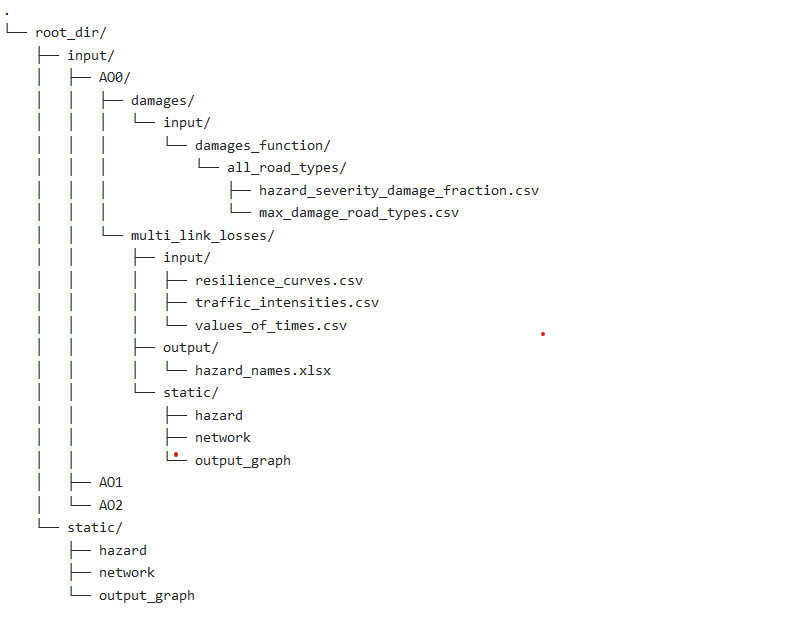

In [8]:

_network_config = NetworkConfigWrapper.from_data(None, _network_config_data)
valid_analysis_ini = root_dir.joinpath("analyses.ini")


_analysis_config = AnalysisConfigWrapper.from_data_with_network(
        valid_analysis_ini, _analysis_data, _network_config
    )

_analysis_input = AnalysisInputWrapper.from_input(
        analysis=_analysis_config.config_data.adaptation,
        analysis_config=_analysis_config,
        graph_file=_analysis_config.graph_files.base_network,
        graph_file_hazard=_analysis_config.graph_files.base_network_hazard,
    )



valid_adaptation_config = (_analysis_input, _analysis_config)
_adaptation = Adaptation(valid_adaptation_config[0], valid_adaptation_config[1])

# 2. Run test.
_benefit = _adaptation.run_benefit()

cost = _adaptation.run_cost()


_res_2 = _adaptation.calculate_bc_ratio(cost_gdf=cost, benefit_gdf=_benefit)
print(_res_2)


# Add modification of climate factor, discount_rate, time_horizon, .... 

2024-12-09 02:31:41 PM - [damage_network_base.py:114] - root - WARNING - Of the 235 road segments, only 26 had lane data, so for 209 the '
                                    lane data will be interpolated from the existing data
2024-12-09 02:31:41 PM - [damage_network_base.py:127] - root - WARNING - Interpolated the missing lane data as follows: {'secondary': 2.0, 'tertiary': 2.0, 'trunk': 2.0}
c:\Users\hauth\miniforge3\envs\ra2ce_env\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
2024-12-09 02:31:42 PM - [damage_network_base.py:114] - root - WARNING - Of the 235 road segments, only 26 had lane data, so for 209 the '
                                    lane data wil

     AO0_impact  AO1_impact  AO1_benefit  AO2_impact  AO2_benefit  \
0      0.000000    0.000000          0.0    0.000000      0.00000   
1      0.065512    0.065512          0.0    0.006782     -0.05873   
2      0.000000    0.000000          0.0    0.000000      0.00000   
3      0.000000    0.000000          0.0    0.000000      0.00000   
4      0.000000    0.000000          0.0    0.000000      0.00000   
..          ...         ...          ...         ...          ...   
225    0.000000    0.000000          0.0    0.000000      0.00000   
226    0.000000    0.000000          0.0    0.000000      0.00000   
227    0.000000    0.000000          0.0    0.000000      0.00000   
228    0.000000    0.000000          0.0    0.000000      0.00000   
229    0.000000    0.000000          0.0    0.000000      0.00000   

         AO1_cost  AO1_bc_ratio      AO2_cost  AO2_bc_ratio  
0    1.893107e+05           0.0  3.663338e+05  0.000000e+00  
1    1.430648e+06           0.0  2.768437e+06 -

In [9]:
_benefit.head(5)  # MISSING Geontry
print(_res_2.columns)

Index(['AO0_impact', 'AO1_impact', 'AO1_benefit', 'AO2_impact', 'AO2_benefit',
       'AO1_cost', 'AO1_bc_ratio', 'AO2_cost', 'AO2_bc_ratio'],
      dtype='object')


In [10]:
_res_2.head(5)

,AO0_impact,AO1_impact,AO1_benefit,AO2_impact,AO2_benefit,AO1_cost,AO1_bc_ratio,AO2_cost,AO2_bc_ratio
0,0.000000,0.000000,0.0,0.000000,0.00000,1.893107e+05,0.0,3.663338e+05,0.000000e+00
1,0.065512,0.065512,0.0,0.006782,-0.05873,1.430648e+06,0.0,2.768437e+06,-2.121409e-08
2,0.000000,0.000000,0.0,0.000000,0.00000,1.920151e+05,0.0,3.715672e+05,0.000000e+00
3,0.000000,0.000000,0.0,0.000000,0.00000,9.735977e+04,0.0,1.884003e+05,0.000000e+00
4,0.000000,0.000000,0.0,0.000000,0.00000,6.490651e+04,0.0,1.256002e+05,0.000000e+00


In [11]:
_res_2["AO2_bc_ratio"].unique()

array([ 0.00000000e+00, -2.12140932e-08, -2.01729290e-04, -1.71739695e-03,
       -3.64250532e-01, -8.22418464e-03, -2.88854588e-01, -3.26003716e-02,
       -7.84584082e-01, -5.14133526e-02, -1.25024986e-01, -3.25617900e-02,
       -3.65097323e-02, -3.33551456e-05, -5.69831324e-02, -1.34500128e+00,
       -4.61785385e-01, -4.97307338e-01, -5.62304717e-04, -3.19829403e-04,
       -2.99295818e-04, -3.50898545e-04, -5.26347817e-04, -2.51927160e-04,
       -3.66139238e+00, -2.37488707e-01, -5.05228923e-08])